<a href="https://colab.research.google.com/github/Romansth/Briksha/blob/main/AI_Model/PlantDiseaseClassifierFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
#Importing and Installing Required Modules and Libraries
!pip install tensorflow
!pip install basic_image_eda
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
sns.set_theme(style="whitegrid")
import cv2
import sys
from re import sub
import tensorflow as tf
from tensorflow.keras import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image_dataset_from_directory


# Load Dataset

In [ ]:
data_dir = r"Downloads/plantvillage-dataset/color/"

# Sample Image

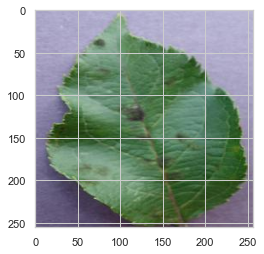

In [ ]:
img = plt.imread(data_dir+"Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG")
plt.imshow(img)

# Exploratory Data Analysis

In [ ]:
category_count = []

for root, dirs, files in os.walk(data_dir):
    for dir_path in dirs:
        category_count.append((dir_path, len(os.listdir(root+os.sep+dir_path))))
count_df = pd.DataFrame(category_count, columns=['Category', 'Count'])
count_df.head(10)

,Category,Count
0,Apple___Apple_scab,630
1,Apple___Black_rot,621
2,Apple___Cedar_apple_rust,275
3,Apple___healthy,1645
4,Blueberry___healthy,1502
5,Cherry_(including_sour)___healthy,854
6,Cherry_(including_sour)___Powdery_mildew,1052
7,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,513
8,Corn_(maize)___Common_rust_,1192
9,Corn_(maize)___healthy,1162


In [ ]:
total_images = count_df['Count'].sum()
total_images

54305

# Data Visualization by Category

[]

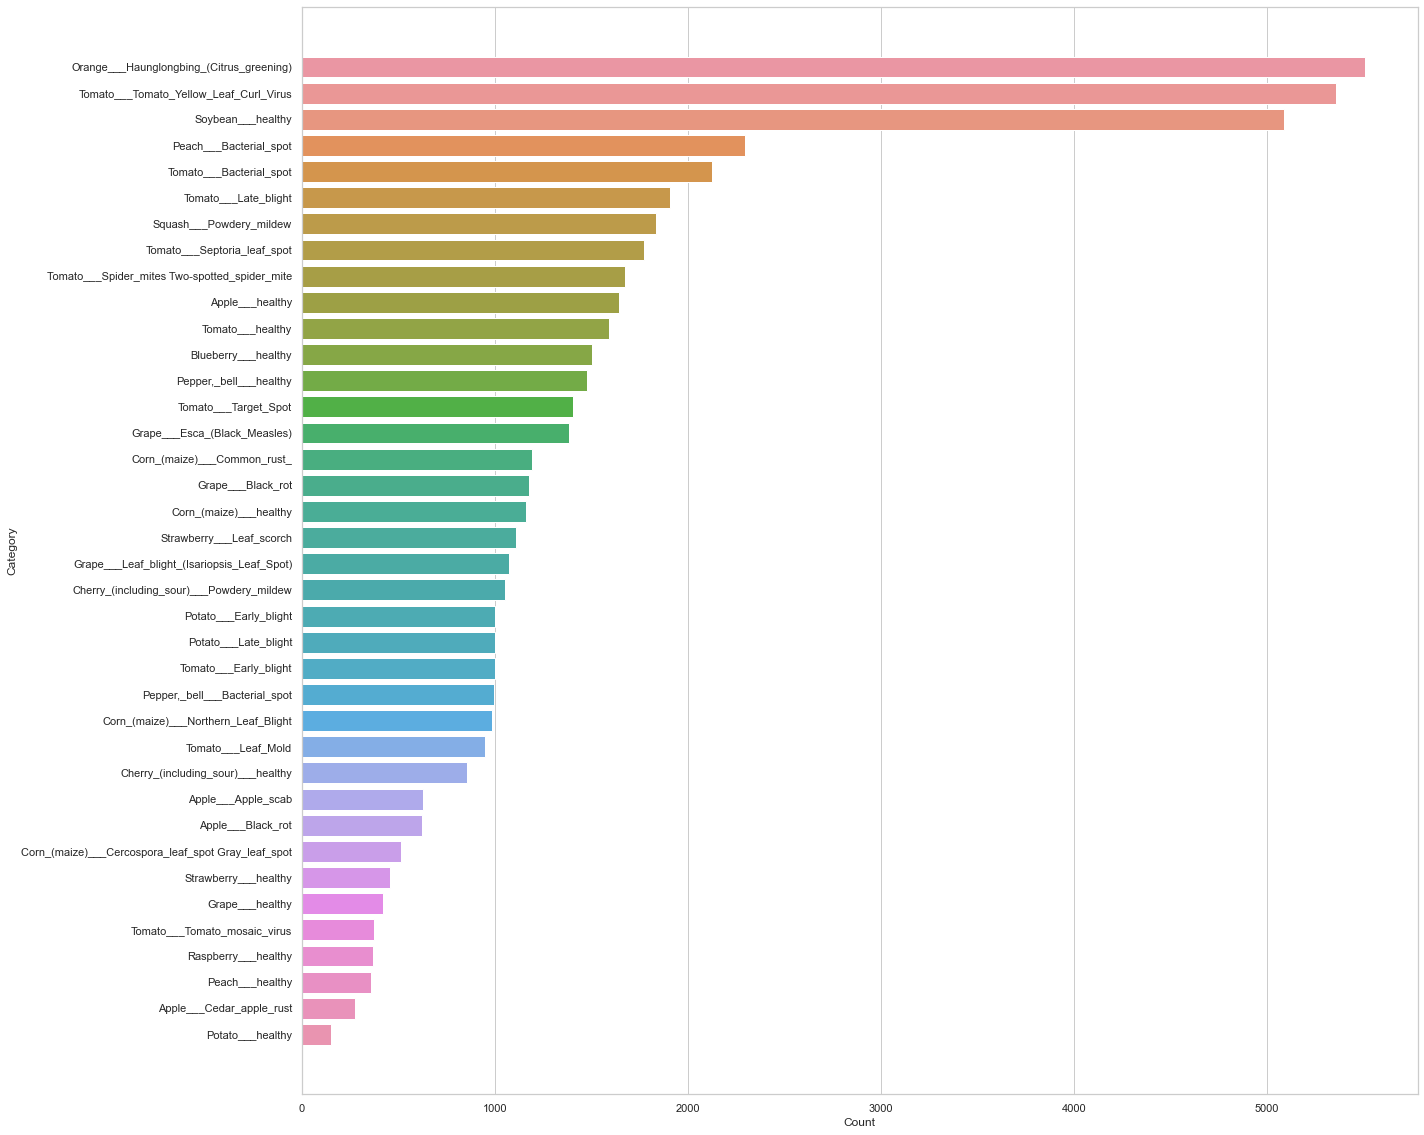

In [ ]:
count_df = count_df.sort_values(by='Count', ascending=False)
plt.figure(figsize=(20,20))
sns.barplot(x="Count", y="Category", data=count_df)
plt.plot()

In [ ]:
healthy_images_count = count_df[count_df['Category'].str.endswith("healthy")]['Count'].sum()
healthy_images_count

15084

In [ ]:
disease_images_count = total_images - healthy_images_count
disease_images_count

39221

[]

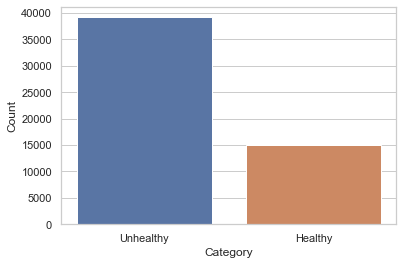

In [ ]:
temp_df = pd.DataFrame(data=[("Unhealthy", disease_images_count), ("Healthy", healthy_images_count)], columns=['Category', 'Count'])
sns.barplot(y="Count",x="Category", data=temp_df)
plt.plot()

# Data Augmentation and Pre-processing

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (240, 240)

In [ ]:
train_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.2,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "training",
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.2,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "validation",
                                             image_size=IMG_SIZE)

Found 54305 files belonging to 38 classes.
Using 43444 files for training.
Found 54305 files belonging to 38 classes.
Using 10861 files for validation.


In [ ]:
class_names = train_dataset.class_names
num_classes = len(class_names)
for i in range(1, num_classes + 1):
    print(str(i) + ". ", class_names[i - 1])

1.  Apple___Apple_scab
2.  Apple___Black_rot
3.  Apple___Cedar_apple_rust
4.  Apple___healthy
5.  Blueberry___healthy
6.  Cherry_(including_sour)___Powdery_mildew
7.  Cherry_(including_sour)___healthy
8.  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
9.  Corn_(maize)___Common_rust_
10.  Corn_(maize)___Northern_Leaf_Blight
11.  Corn_(maize)___healthy
12.  Grape___Black_rot
13.  Grape___Esca_(Black_Measles)
14.  Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
15.  Grape___healthy
16.  Orange___Haunglongbing_(Citrus_greening)
17.  Peach___Bacterial_spot
18.  Peach___healthy
19.  Pepper,_bell___Bacterial_spot
20.  Pepper,_bell___healthy
21.  Potato___Early_blight
22.  Potato___Late_blight
23.  Potato___healthy
24.  Raspberry___healthy
25.  Soybean___healthy
26.  Squash___Powdery_mildew
27.  Strawberry___Leaf_scorch
28.  Strawberry___healthy
29.  Tomato___Bacterial_spot
30.  Tomato___Early_blight
31.  Tomato___Late_blight
32.  Tomato___Leaf_Mold
33.  Tomato___Septoria_leaf_spot
34.  Tomato_

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 272
Number of test batches: 68


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# added augmentations
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

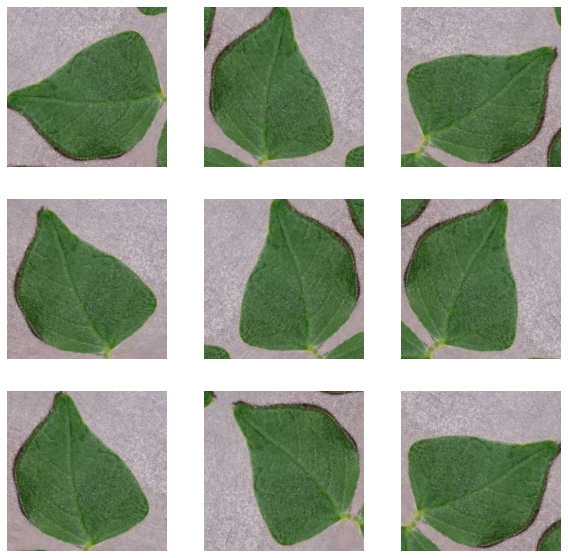

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Metrics and Plotting functions

In [ ]:
def plot_metrics(history):
  colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
  metrics = ['loss', 'auc', 'precision', 'recall']
  plt.figure(figsize=(20,10))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [ ]:
METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.CategoricalAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc')
]

## Load and compile model

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)

In [ ]:
preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input

In [ ]:
base_model = tf.keras.applications.InceptionResNetV2(
                                include_top=False,
                                weights="imagenet",
                                input_shape=IMG_SHAPE,
                            )

219070464/219055592 [==============================] - 1s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1536)


In [ ]:
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

print(feature_batch_average.shape)

(32, 1536)


In [ ]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 38)


In [ ]:
inputs = tf.keras.Input(shape=(240, 240, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=METRICS)

C:\Users\roman\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 240, 240, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 240, 240, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 240, 240, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 6, 6, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0     

# Training, Validation and Testing

Before tuning

In [ ]:
initial_epochs = 10

In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


C:\Users\roman\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\backend.py:4846: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


1358/1358 [==============================] - 3620s 3s/step - loss: 0.8491 - tp: 27133.0000 - fp: 2299.0000 - tn: 1605129.0000 - fn: 16311.0000 - accuracy: 0.7646 - precision: 0.9219 - recall: 0.6246 - auc: 0.9872 - val_loss: 0.4727 - val_tp: 6783.0000 - val_fp: 552.0000 - val_tn: 320793.0000 - val_fn: 1902.0000 - val_accuracy: 0.8558 - val_precision: 0.9247 - val_recall: 0.7810 - val_auc: 0.9963
Epoch 2/10
1358/1358 [==============================] - 3638s 3s/step - loss: 0.4329 - tp: 35232.0000 - fp: 2742.0000 - tn: 1604686.0000 - fn: 8212.0000 - accuracy: 0.8704 - precision: 0.9278 - recall: 0.8110 - auc: 0.9959 - val_loss: 0.3538 - val_tp: 7359.0000 - val_fp: 482.0000 - val_tn: 320863.0000 - val_fn: 1326.0000 - val_accuracy: 0.8940 - val_precision: 0.9385 - val_recall: 0.8473 - val_auc: 0.9975
Epoch 3/10
1358/1358 [==============================] - 3650s 3s/step - loss: 0.3622 - tp: 36849.0000 - fp: 2775.0000 - tn: 1604653.0000 - fn: 6595.0000 - accuracy: 0.8884 - precision: 0.9300 

After tunung

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 700

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  780


In [ ]:
fine_tuning_learning_rate = 1e-5
model.compile(optimizer=tf.keras.optimizers.Adam(lr=fine_tuning_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=METRICS)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 240, 240, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 240, 240, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 240, 240, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 6, 6, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0     

In [ ]:
len(model.trainable_variables)

52

In [ ]:
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/25
1358/1358 [==============================] - 4612s 3s/step - loss: 0.1686 - tp: 48421.0000 - fp: 2225.0000 - tn: 1926548.0000 - fn: 3708.0000 - accuracy: 0.9417 - precision: 0.9561 - recall: 0.9289 - auc: 0.9986 - val_loss: 0.1119 - val_tp: 8311.0000 - val_fp: 257.0000 - val_tn: 321088.0000 - val_fn: 374.0000 - val_accuracy: 0.9623 - val_precision: 0.9700 - val_recall: 0.9569 - val_auc: 0.9994
Epoch 11/25
1358/1358 [==============================] - 4582s 3s/step - loss: 0.1174 - tp: 41435.0000 - fp: 1324.0000 - tn: 1606104.0000 - fn: 2009.0000 - accuracy: 0.9610 - precision: 0.9690 - recall: 0.9538 - auc: 0.9994 - val_loss: 0.0894 - val_tp: 8389.0000 - val_fp: 201.0000 - val_tn: 321144.0000 - val_fn: 296.0000 - val_accuracy: 0.9705 - val_precision: 0.9766 - val_recall: 0.9659 - val_auc: 0.9995
Epoch 12/25
1358/1358 [==============================] - 4581s 3s/step - loss: 0.0936 - tp: 41898.0000 - fp: 1106.0000 - tn: 1606322.0000 - fn: 1546.0000 - accuracy: 0.9692 - precisi

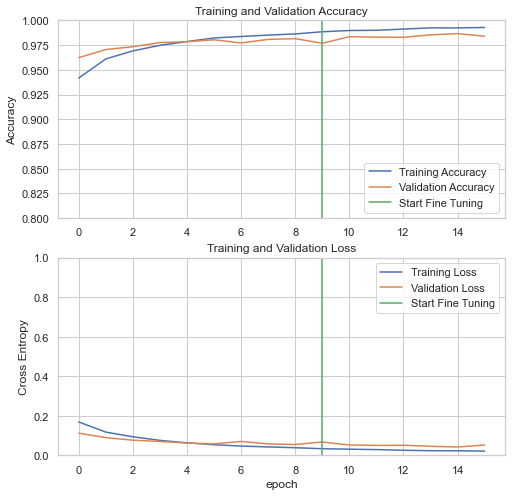

In [ ]:
acc = []          
val_acc = []
loss = []     
val_loss = []

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']



plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy')
plt.show()

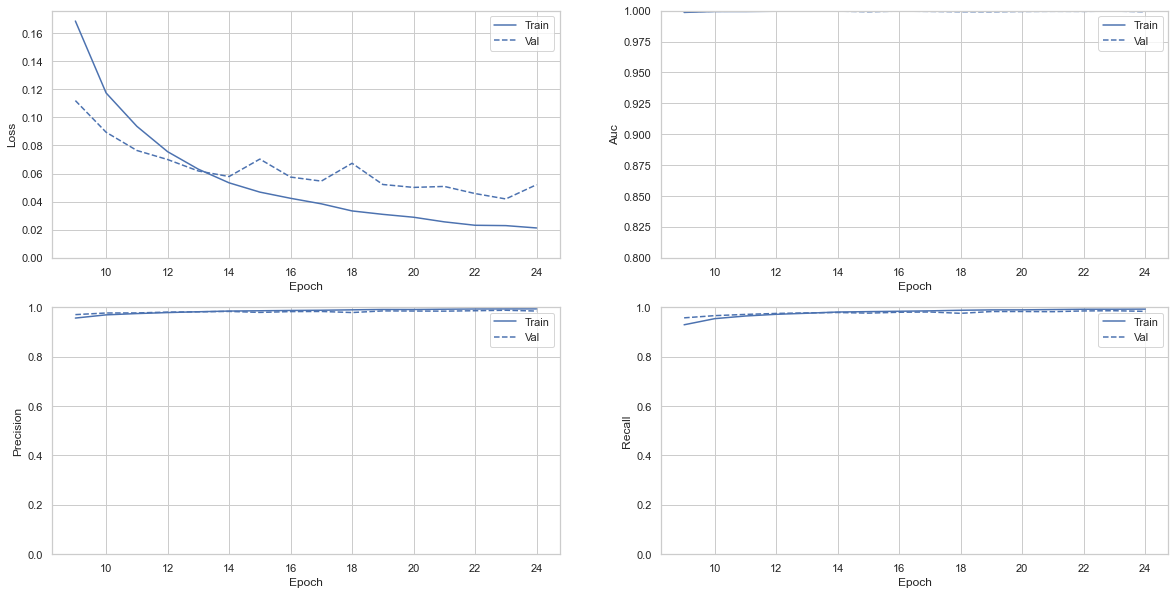

In [ ]:
plot_metrics(history_fine)

In [ ]:
result = model.evaluate(test_dataset)

68/68 [==============================] - 151s 2s/step - loss: 0.0483 - tp: 2143.0000 - fp: 30.0000 - tn: 80482.0000 - fn: 33.0000 - accuracy: 0.9853 - precision: 0.9862 - recall: 0.9848 - auc: 0.9995


In [ ]:
metrics = ["loss", "tp", "fp", "tn", "fn", "accuracy", "precision", "recall", "auc"]
for i in range(len(result)):
    print("{} : {}".format(metrics[i],round(result[i], 3)))

loss : 0.048
tp : 2143.0
fp : 30.0
tn : 80482.0
fn : 33.0
accuracy : 0.985
precision : 0.986
recall : 0.985
auc : 1.0


Predictions:
 [12, 24, 10, 29, 24, 16, 19, 30, 16, 29, 35, 11, 31, 35, 11, 4, 24, 16, 11, 21, 35, 16, 16, 16, 35, 0, 4, 5, 4, 13, 35, 33]
Labels:
 [12, 24, 10, 29, 24, 16, 19, 30, 16, 29, 35, 11, 31, 35, 11, 4, 24, 16, 11, 21, 35, 16, 16, 16, 35, 0, 4, 5, 4, 13, 35, 33]


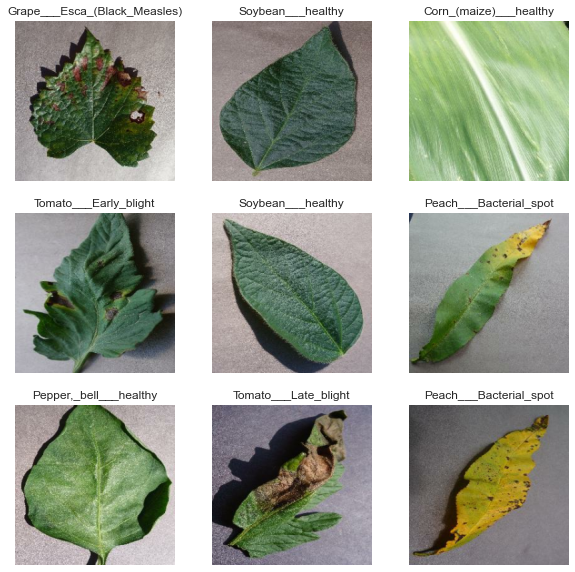

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

predictions = tf.nn.softmax(predictions)
predictions = list(np.argmax(x) for x in predictions.numpy())

print('Predictions:\n', predictions)
print('Labels:\n', list(np.argmax(x) for x in label_batch))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

# Save Model

In [ ]:
# save model in JSON format
model_json = model.to_json()
json_file = open("model_weights.json", "w")
json_file.write(model_json)
print("Model saved in JSON format!")
    
# save training weights in h5 file
model.save_weights("model_weights.h5")
print("\nModel weights saved!")

Model saved in JSON format!

Model weights saved!


In [ ]:
model.save("inception_V3.0_fineTuning.h5")